# Projeto 1 - Ciência dos Dados

Nome: Danilo Ramos

Nome: Leonardo Veras

Nome: Thomas Ganut

Atenção: Serão permitidos grupos de até 4 pessoas, mas com uma rubrica mais exigente. 

___
Carregando algumas bibliotecas:

In [75]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import display
import re

Carregando a base de dados com as mensagens dos seus arquivos:

In [76]:
test = pd.read_csv('dados_teste_QUARTETO_Danilo_Leonardo_Thomas.csv')
train = pd.read_csv('dados_treino_QUARTETO_Danilo_Leonardo_Thomas.csv')

print(f'{len(test)}   (Tamanho das listas de treino e teste) ')

1800   (Tamanho das listas de treino e teste) 


___
## Classificador automático


Faça aqui uma descrição do seu assunto e o contexto referente aos rótulos cujas mensagens (ou reviews) deverão ser classificadas.

Será desenvolvido um sistema automático, utilizando o Teorema de Bayes, para classificar textos científicos em física, química e biologia. Uma prova de conceito será implementada para treinar e testar o classificador, garantindo a separação clara dos textos nas respectivas áreas.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [77]:
punctuation = '[´`"!-.:?;$''^~)(&€™/]'

def cleanup(text):
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text).replace(("\\n"),' ')
    return text_subbed

In [94]:
# Define stop words

list_train: list = []
n = 2
for frase in train.Comment:
    frase = cleanup(frase)
    frase = frase.split()
    list_train.extend([' '.join(frase[i:i+n]) for i in range(len(frase)-n+1)])
        # print([frase[i],frase[i+1],frase[i+2]])

serie_train = pd.Series(list_train)
tabela = serie_train.value_counts()

stop_words = tabela.index[:15].tolist()
for i in range(len(stop_words)):
    stop_words[i] = stop_words[i].lower()
stop_words.extend(['thank', 'you', 'thank you'])
print(stop_words)


['in the', 'of the', 'to the', 'to be', 'it is', 'on the', 'is a', 'this is', 'for the', 'i think', 'in a', 'the same', 'would be', 'is the', 'and the', 'thank', 'you', 'thank you']


In [79]:
def cleanup_stopwords(frase):
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', frase.lower())
    text_subbed = text_subbed.replace(("\\n"),' ').replace(("\n"),' ')
    for palavra in stop_words:
        text_subbed = text_subbed.replace((f' {palavra} '), ' ')

    return text_subbed

# print(cleanup_stopwords(' be able to a to I of and is in probably partially true thank you '))

In [80]:
for i, frase in enumerate(train.Comment):
    train.Comment[i] = cleanup_stopwords(frase.lower())

list_train: list = []
for frase in train.Comment:
    frase = frase.split()
    list_train.extend([' '.join(frase[i:i+n]) for i in range(len(frase)-n+1)])
        
serie_train = pd.Series(list_train)

serie_train.value_counts(True)

there is no          0.000262
alan alan alan       0.000248
but i think          0.000197
this is the          0.000197
the fact that        0.000182
                       ...   
large scale it       0.000007
on a large           0.000007
place on a           0.000007
takes place on       0.000007
name a duckstream    0.000007
Name: proportion, Length: 121189, dtype: float64

In [81]:
train_physics = train.loc[train.Topic == 'Physics']
train_biology = train.loc[train.Topic == 'Biology']
train_chemistry = train.loc[train.Topic == 'Chemistry']

In [82]:
# Função para transformar frases em lista de palavras
def frase_para_palavras(lista_frases):
    lista_palavras = []
    for frase in lista_frases:
        lista_palavras.extend(frase.split())
    return lista_palavras

# Gerando as listas de palavras por tópico
lista_physics = frase_para_palavras(train_physics.Comment)
lista_biology = frase_para_palavras(train_biology.Comment)
lista_chemistry = frase_para_palavras(train_chemistry.Comment)

# Criando séries de frequência
serie_physics = pd.Series(lista_physics)
serie_biology = pd.Series(lista_biology)
serie_chemistry = pd.Series(lista_chemistry)


In [83]:
P_C = len(serie_chemistry)/len(serie_train)
P_B = len(serie_biology)/len(serie_train)
P_P = len(serie_physics)/len(serie_train)

print(f'P(C): {P_C:.3f}, P(B): {P_B:.3f}, P(P): {P_P:.3f}')
print(f'P(C) + P(B) + P(P) = {P_C + P_B + P_P:.2f}')

P(C): 0.318, P(B): 0.401, P(P): 0.341
P(C) + P(B) + P(P) = 1.06


In [84]:
# Treinamento
tabela_c_relativa = serie_chemistry.value_counts(True)
tabela_p_relativa = serie_physics.value_counts(True)
tabela_b_relativa = serie_biology.value_counts(True)

voc = tabela.count()

# Physics
tabela_P_raw = serie_physics.value_counts()
tabela_P_freq = tabela_P_raw.sum()
tabela_P_voc = tabela_P_raw.count()

# Chemistry
tabela_C_raw = serie_chemistry.value_counts()
tabela_C_freq = tabela_C_raw.sum()
tabela_C_voc = tabela_C_raw.count()

# Biology
tabela_B_raw = serie_biology.value_counts()
tabela_B_freq = tabela_B_raw.sum()
tabela_B_voc = tabela_B_raw.count()


___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [85]:
def algoritmo_1(frase: str) -> str:
    probPalavraDadoP = probPalavraDadoC = probPalavraDadoB = 1
    
    for palavra in frase.split():
        probPalavraDadoB *= tabela_b_relativa.get(palavra, 1e-6)
        probPalavraDadoP *= tabela_p_relativa.get(palavra, 1e-6)
        probPalavraDadoC *= tabela_c_relativa.get(palavra, 1e-6)

    prob_P_dado_frase = probPalavraDadoP * P_P
    prob_C_dado_frase = probPalavraDadoC * P_C
    prob_B_dado_frase = probPalavraDadoB * P_B

    if  prob_P_dado_frase > prob_C_dado_frase:
        if prob_P_dado_frase > prob_B_dado_frase:
            return 'Physics'
        else:
            return 'Biology'
    else:
        if prob_C_dado_frase > prob_B_dado_frase:
            return 'Chemistry'
        else:
            return 'Biology'

In [86]:
def algoritmo_laplace(frase: str):
    alpha = 1 # Suavizador de Laplace
    probPalavraDadoP = probPalavraDadoC = probPalavraDadoB = 1

    for palavra in frase.split():
        probPalavraDadoB *= (tabela_B_raw.get(palavra, 0) + alpha) / (tabela_B_freq + alpha * voc)

        probPalavraDadoP *= (tabela_P_raw.get(palavra, 0) + alpha) / (tabela_P_freq + alpha * voc)

        probPalavraDadoC *= (tabela_C_raw.get(palavra, 0) + alpha) / (tabela_C_freq + alpha * voc)

             
    prob_P_dado_frase = probPalavraDadoP * P_P
    prob_C_dado_frase = probPalavraDadoC * P_C
    prob_B_dado_frase = probPalavraDadoB * P_B

    if  prob_P_dado_frase > prob_C_dado_frase:
        if prob_P_dado_frase > prob_B_dado_frase:
            return 'Physics'
        else:
            return 'Biology'
    else:
        if prob_C_dado_frase > prob_B_dado_frase:
            return 'Chemistry'
        else:
            return 'Biology'

In [87]:
# Algoritmo com Laplace utilizando log-probabilidades
def algoritmo_laplace_log(frase: str, alpha=1):
    lista_palavras = frase.split()
    
    # Inicializar log-probabilidades com log das probabilidades das classes
    log_prob_P = np.log(P_P)
    log_prob_C = np.log(P_C)
    log_prob_B = np.log(P_B)
    
    for palavra in lista_palavras:
        count_p = tabela_P_raw.get(palavra, 0)
        log_prob_P += np.log((count_p + alpha) / (tabela_P_freq + alpha * voc))
        
        count_c = tabela_C_raw.get(palavra, 0)
        log_prob_C += np.log((count_c + alpha) / (tabela_C_freq + alpha * voc))
        
        count_b = tabela_B_raw.get(palavra, 0)
        log_prob_B += np.log((count_b + alpha) / (tabela_B_freq + alpha * voc))
    
    if log_prob_P > log_prob_C:
        if log_prob_P > log_prob_B:
            return 'Physics'
        else:
            return 'Biology'
    else:
        if log_prob_C > log_prob_B:
            return 'Chemistry'
        else:
            return 'Biology'

In [88]:
validacao = test.copy()
validacao['algo1_certa'] = False
validacao['algoL_certa'] = False
validacao['algoL_log_certa'] = False

validacao['algo1'] = 'NaN'
validacao['algoL'] = 'NaN'
validacao['algoL_log'] = 'NaN'

for i, frase in enumerate(test.Comment):
    frase = cleanup_stopwords(frase)
    validacao.loc[i, 'algo1'] = algoritmo_1(frase)
    validacao.loc[i, 'algoL'] = algoritmo_laplace(frase)
    validacao.loc[i, 'algoL_log'] = algoritmo_laplace_log(frase)
  
    if validacao.loc[i, 'algo1'] == validacao.loc[i, 'Topic']:
        validacao.loc[i, 'algo1_certa'] = True

    if validacao.loc[i, 'algoL'] == validacao.loc[i, 'Topic']:
        validacao.loc[i, 'algoL_certa'] = True

    if validacao.loc[i, 'algoL_log'] == validacao.loc[i, 'Topic']:
        validacao.loc[i, 'algoL_log_certa'] = True


In [89]:
acertos_algo1 = validacao.algo1_certa.value_counts(True)
acertos_algoL = validacao.algoL_certa.value_counts(True)
acertos_algoL_log = validacao.algoL_log_certa.value_counts(True)

print('Acertos sem Laplace: ')
print(f'{acertos_algo1[True]*100:.2f}%')
print('\nAcertos com Laplace:')
print(f'{acertos_algoL[True]*100:.2f}%')
print('\nAcertos com Laplace com log:')
print(f'{acertos_algoL_log[True]*100:.2f}%')

Acertos sem Laplace: 
68.33%

Acertos com Laplace:
64.39%

Acertos com Laplace com log:
68.61%


In [90]:
# Exibe as tabelas de contingência para as previsões dos algoritmos
display(pd.crosstab(test.Topic, validacao.algo1_certa))
display(pd.crosstab(test.Topic, validacao.algoL_certa))
display(pd.crosstab(test.Topic, validacao.algoL_log_certa))

# Calcula as taxas de acerto para os algoritmos
taxa_acerto_1 = [validacao.algo1_certa.value_counts().iloc[0], validacao.algo1_certa.value_counts().iloc[1]]
taxa_acerto_L = [validacao.algoL_certa.value_counts().iloc[0], validacao.algoL_certa.value_counts().iloc[1]]
taxa_acerto_L_log = [validacao.algoL_log_certa.value_counts().iloc[0], validacao.algoL_log_certa.value_counts().iloc[1]]

# Análise para Biologia
validacao_biologia = validacao.loc[validacao.Topic == 'Biology']
taxa_acerto_bio_L = validacao_biologia.algoL.value_counts(True).iloc[0]
validacao_biologia_algoL_acertos = validacao_biologia.algoL.value_counts().iloc[0]
taxa_acerto_bio_1 = validacao_biologia.algo1.value_counts(True).iloc[0]
print(f' Taxa de acertos em biologia com Laplace: {taxa_acerto_bio_L}', '\n', f'Taxa de acertos em biologia sem Laplace: {taxa_acerto_bio_1}')
print('\n')

# Análise para Física
validacao_physics = validacao.loc[validacao.Topic == 'Physics']
taxa_acerto_ph_L = validacao_physics.algoL.value_counts(True).iloc[0]
taxa_acerto_ph_1 = validacao_physics.algo1.value_counts(True).iloc[0]
print(f' Taxa de acertos em física com Laplace: {taxa_acerto_ph_L}', '\n', f'Taxa de acertos em física sem Laplace: {taxa_acerto_ph_1}')
print('\n')

# Análise para Química
validacao_chemistry = validacao.loc[validacao.Topic == 'Chemistry']
taxa_acerto_ch_L = validacao_chemistry.algoL.value_counts(True).iloc[0]
taxa_acerto_ch_1 = validacao_chemistry.algo1.value_counts(True).iloc[0]
print(f' Taxa de acertos em química com Laplace: {taxa_acerto_ch_L}', '\n', f'Taxa de acertos em química sem Laplace: {taxa_acerto_ch_1}')


algo1_certa,False,True
Topic,,
Biology,146,591
Chemistry,229,369
Physics,195,270


algoL_certa,False,True
Topic,,
Biology,61,676
Chemistry,352,246
Physics,228,237


algoL_log_certa,False,True
Topic,,
Biology,64,673
Chemistry,320,278
Physics,181,284


 Taxa de acertos em biologia com Laplace: 0.9172320217096337 
 Taxa de acertos em biologia sem Laplace: 0.8018995929443691


 Taxa de acertos em física com Laplace: 0.5096774193548387 
 Taxa de acertos em física sem Laplace: 0.5806451612903226


 Taxa de acertos em química com Laplace: 0.4983277591973244 
 Taxa de acertos em química sem Laplace: 0.617056856187291


Topic,Biology
algoL_certa,
False,61
True,676


<Figure size 640x480 with 0 Axes>

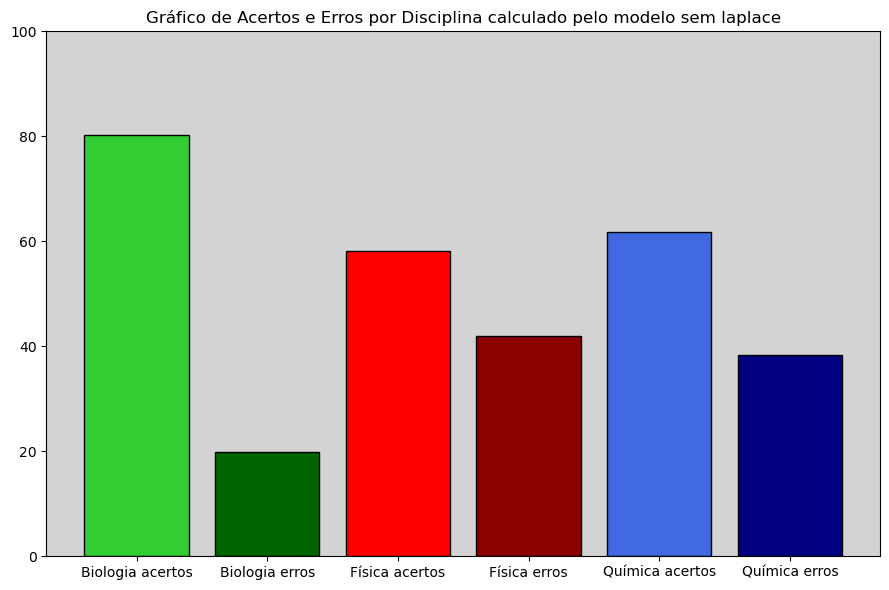

In [91]:
cross_L = pd.crosstab(validacao_biologia.Topic, validacao_biologia.algoL_certa)
display(pd.crosstab(validacao_biologia.algoL_certa, validacao_biologia.Topic))
plt.figure()

fig, ax = plt.subplots(figsize=(9, 6))

categorias = ['Biologia acertos', 'Biologia erros', 'Física acertos', 'Física erros', 'Química acertos', 'Química erros']
posicoes = np.arange(1,len(categorias) + 1)

ax.bar(1, taxa_acerto_bio_1 *100, edgecolor='black', color='limegreen')
ax.bar(2, ((1 - taxa_acerto_bio_1)*100),edgecolor='black', color='darkgreen')

ax.bar(3, taxa_acerto_ph_1*100, edgecolor='black', color='Red')
ax.bar(4, ((1 - taxa_acerto_ph_1)*100),edgecolor='black', color='darkred')

ax.bar(5, taxa_acerto_ch_1*100, edgecolor='black', color='royalblue')
ax.bar(6, ((1 - taxa_acerto_ch_1)*100), edgecolor='black', color='navy')

ax.set_facecolor('lightgray')

# ax.pie(taxa_acerto_1, colors=['Green','Blue'], radius=0.4, center=(7, 0.4),
#        wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=True)

ax.set_ylim(0, 100)
plt.xticks(posicoes, categorias, ha='center')
plt.title('Gráfico de Acertos e Erros por Disciplina calculado pelo modelo sem laplace')
plt.tight_layout()  # Ajusta para evitar sobreposição


plt.show()

Topic,Biology
algoL_certa,
False,61
True,676


<Figure size 640x480 with 0 Axes>

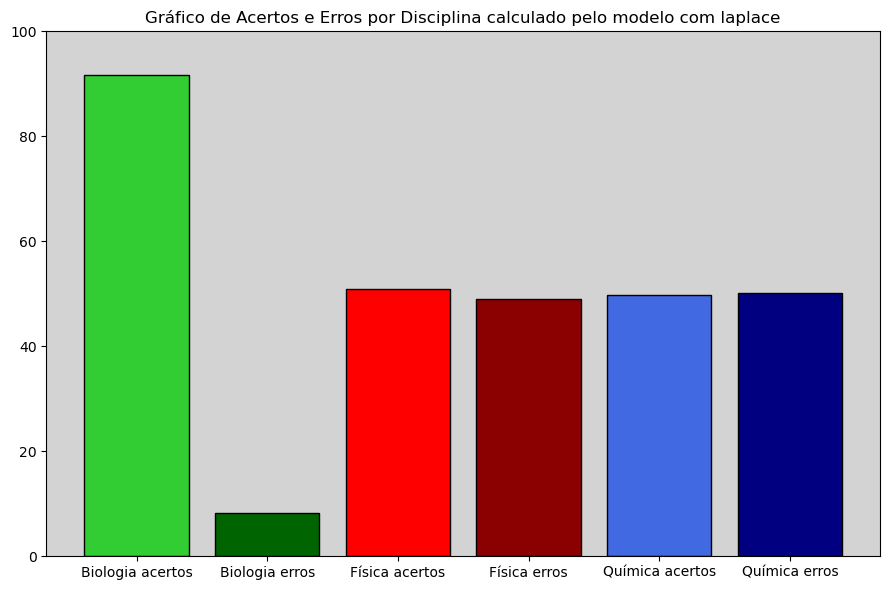

In [92]:
cross_L = pd.crosstab(validacao_biologia.Topic, validacao_biologia.algoL_certa)
display(pd.crosstab(validacao_biologia.algoL_certa, validacao_biologia.Topic))
plt.figure()

fig, ax = plt.subplots(figsize=(9, 6))

categorias = ['Biologia acertos', 'Biologia erros', 'Física acertos', 'Física erros', 'Química acertos', 'Química erros']
posicoes = np.arange(1,len(categorias) + 1)

ax.bar(1, taxa_acerto_bio_L *100, edgecolor='black', color='limegreen')
ax.bar(2, ((1 - taxa_acerto_bio_L)*100),edgecolor='black', color='darkgreen')

ax.bar(3, taxa_acerto_ph_L*100, edgecolor='black', color='Red')
ax.bar(4, ((1 - taxa_acerto_ph_L)*100),edgecolor='black', color='darkred')

ax.bar(5, taxa_acerto_ch_L*100, edgecolor='black', color='royalblue')
ax.bar(6, ((1 - taxa_acerto_ch_L)*100), edgecolor='black', color='navy')

ax.set_facecolor('lightgray')

ax.set_ylim(0, 100)
plt.xticks(posicoes, categorias, ha='center')
plt.title('Gráfico de Acertos e Erros por Disciplina calculado pelo modelo com laplace')
plt.tight_layout()  # Ajusta para evitar sobreposição

plt.show()

<Figure size 640x480 with 0 Axes>

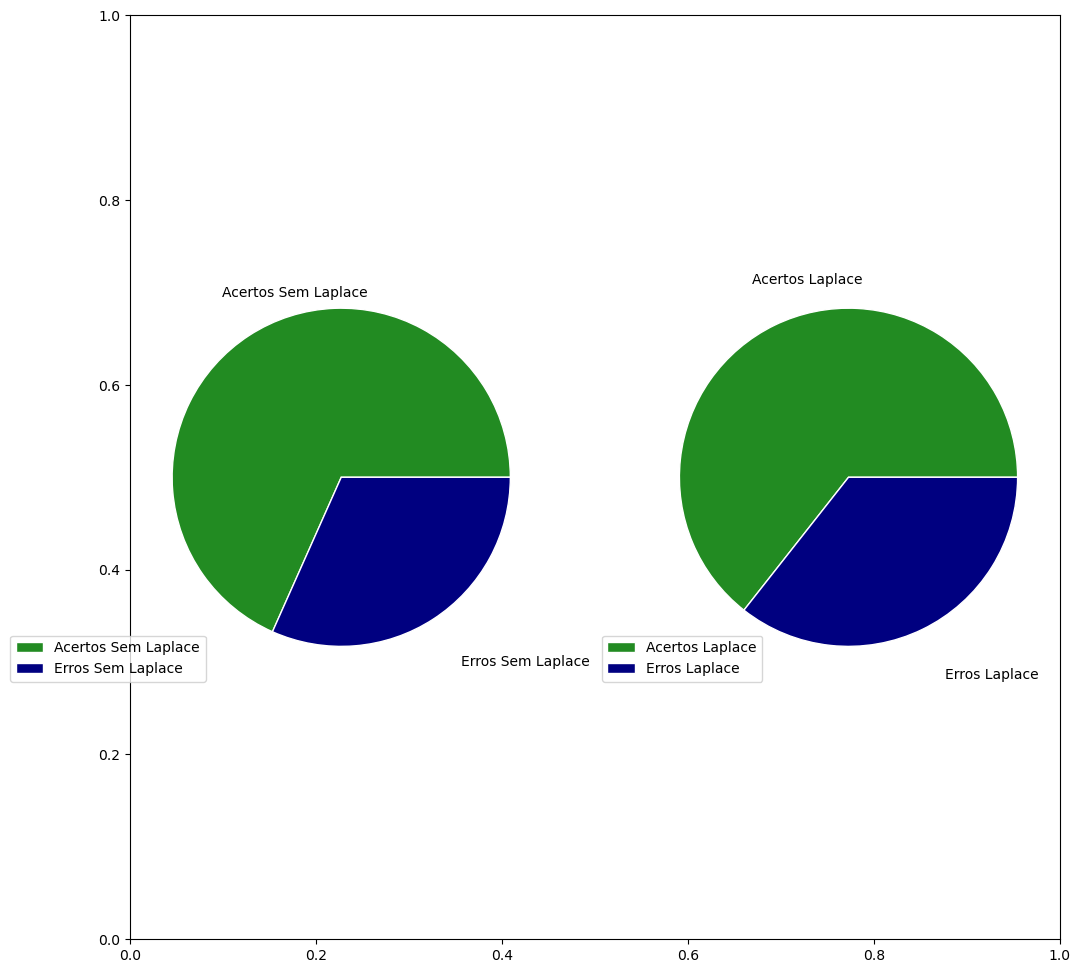

In [93]:
plt.figure()

fig = plt.subplots(figsize=(12, 12))

plt.subplot(121)
plt.pie(taxa_acerto_1, colors=['forestgreen','navy'], radius=1, center=(1, 1),
        wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=False, labels=['Acertos Sem Laplace','Erros Sem Laplace'], labeldistance=1.3)
plt.xlabel = 'Acertos e erros do algoritmo sem laplace'
plt.legend(loc='lower left', bbox_to_anchor=(-0.3,0))

plt.subplot(122)
plt.pie(taxa_acerto_L, colors=['forestgreen','navy'], radius=1, center=(1, 1),
        wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=False, labels=['Acertos Laplace','Erros Laplace'], labeldistance=1.3)
plt.xlabel = 'Acertos e erros do algoritmo com laplace'

plt.legend(loc='lower left', bbox_to_anchor=(-0.1,0))
plt.show()

___
### Concluindo

___
### Qualidade do Classificador a partir de novas separações das mensagens entre Treinamento e Teste

Caso for fazer esse item do Projeto

___
## Aperfeiçoamento:

Leia atentamente a rubrica colocada no enunciado do Projeto 1 (última página). <br>
Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nas mensagens, mas tendem a melhorar na classificação das mensagens. Ex: stemming, lemmatization, stopwords.
* CONSIDEROU arquivo com três categorias na classificação das variáveis (OBRIGATÓRIO PARA QUARTETOS, sem contar como item avançado)
* CONSTRUIU o cálculo das probabilidades corretamente utilizando bigramas E apresentou referência sobre o método utilizado.
* EXPLICOU porquê não pode usar novas mensagens classificadas pelo próprio classificador como amostra de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários diferentes, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* REFLETE criticamente sobre os resultados obtidos, identificando limitações do modelo e sugerindo possíveis melhorias ou diferentes abordagens com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa).
* DOCUMENTOU bem o código, com explicações claras para cada etapa do processo, incluindo o raciocínio por trás das decisões de modelagem e das transformações de dados.


___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**